In [1]:
import numpy as np
import scipy as sp
import scipy.sparse as spsp
import scipy.sparse.linalg as spsplin
import math
from scipy.sparse.linalg import spsolve
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(linewidth=400,precision=10,suppress=True)

# Partie 1: Lanczos

## Question 1: 

In [2]:
def iter_Arnoldi_sym(A,v,vold,beta):
    assert A.shape[0]==v.size == vold.size
    w = np.zeros_like(v)
    w = A@v
    alpha = w@v
    w-=alpha*v + beta*vold
    beta = np.linalg.norm(w)
    vold[:] = v[:]
    v[:] = w[:]/beta
    return alpha, beta
 

In [3]:
"""test"""
def Arnoldi_sym_test(n):
    A = np.ones((n,n))
    vold=np.ones(n)/np.sqrt(n)
    v=np.ones(n)/np.sqrt(n)
    beta = 1
    alpha, beta = iter_Arnoldi_sym(A,v,vold,beta)
    print("alpha = \n",alpha)
    print("beta = \n",beta)
    return alpha, beta
    
alpha, beta = Arnoldi_sym_test(4)

alpha = 
 4.0
beta = 
 1.0


## Question 2: 

In [4]:
def Lanczos(A,nbiter):
    n = A.shape[0]
    assert n >= nbiter
    v = np.random.rand(n)
    v = v/ np.linalg.norm(v)
    vold = np.random.rand(n)
    vold = vold/ np.linalg.norm(vold)
    beta = 0
    Tdiag =[]
    Tdiagsup =[]
    eigval = np.zeros((n,n)) #[] #autre alternative
    for i in range(1,nbiter+1):
        alpha,beta = iter_Arnoldi_sym(A,v,vold,beta)
        Tdiag.append(alpha)
        T = np.diag(Tdiag) +np.diag(Tdiagsup,1)+np.diag(Tdiagsup,-1)
        Tdiagsup.append(beta)
        eigval[i-1,0:i] =np.linalg.eig(T)[0][:] #eigval.append(np.linalg.eig(T)[0])
        
    return eigval

# Question 3: 

In [5]:
"""test"""
def A_csr(d):
    n = d*d
    A = spsp.diags([[4.]*n,[-1]*(n-1),[-1]*(n-1),[-1]*(n-d),[-1]*(n-d)],
                   [0,1,-1,d,-d])
    A = spsp.csc_matrix(A)
    
    return A

In [6]:
"""stocker la matrice test en csr"""
d = 2
n = d*d
A = A_csr(d)

In [7]:
%%time
"""valeur propre par l'algo"""
nbiter = n
eigval = Lanczos(A,nbiter)

print("Les valeur propre de l'algo: Lanczos =\n\n",eigval[-1])

Les valeur propre de l'algo: Lanczos =

 [1.4384471872 4.           5.5615528128 5.          ]
Wall time: 1.01 s


In [8]:
A = A.toarray()

In [9]:
%%time
"""valeur propre par numpy"""
valprop =  np.linalg.eig(A)[0]
print("Les valeur propre de np.linalg.eig = \n\n",valprop)

Les valeur propre de np.linalg.eig = 

 [1.4384471872 4.           5.5615528128 5.          ]
Wall time: 15.6 ms


***Commentaire:***

$$Pour: \, \, \, n= 4$$
$$
\begin{array}{|l|c|c|}
\hline
\text{valeurs propres} & Lancsos \,& Numpy \\
\hline
\text{Temps (ms)} & 3&1 \\
\hline
\end{array}
$$

$$Pour: \, \, \, n= 100$$
$$
\begin{array}{|l|c|c|}
\hline
\text{valeurs propres} & Lancsos \,& Numpy \\
\hline
\text{Temps (ms)} & 1960&28 \\
\hline
\end{array}
$$

$$Pour: \, \, \, n= 400$$
$$
\begin{array}{|l|c|c|}
\hline
\text{valeurs propres} & Lancsos \,& Numpy \\
\hline
\text{Temps (ms)} & 3600&206 \\
\hline
\end{array}
$$

On a estimé le temps de calcul pour différentes tailles de matrice test `A` et le calcul des valeurs propres par le module scipy est bien plus rapide que l'algorithme de `Lanczos` en prenant`nbiter = taille(A)`.

### Convergence de la valeur de Ritz (grande --> grande):

In [10]:
def Ritz_max(A,nbiter):
    eigval = Lanczos(A,nbiter)
    """calcul de la plus grand valeurs propre"""
    maxval = np.max(eigval,axis=1)
    return maxval

In [11]:
"""valeur propres de Ritz"""
d = 10
nbiter = 40
A = A_csr(d)
maxval = Ritz_max(A,nbiter)

"""plus grande valeur propre exacte """
maxval_exact = np.max(np.linalg.eig(A.toarray())[0])

"""erreur de Ritz"""
erreur_ritz_max = np.abs(maxval[0:nbiter]-maxval_exact)

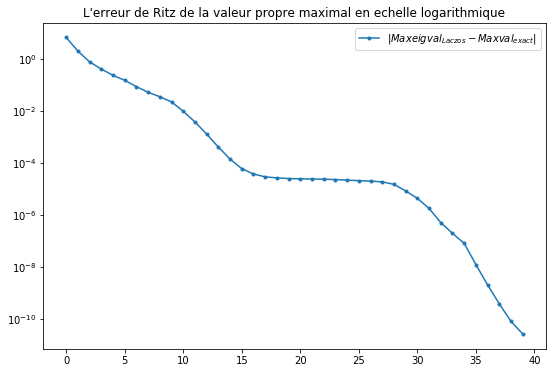

In [12]:
fig,ax = plt.subplots(1,figsize=(9,6),sharex=True)
ax.set_title(r"L'erreur de Ritz de la valeur propre maximal en echelle logarithmique")
ax.plot(erreur_ritz_max, ".-",label=r'$|Maxeigval_{Laczos}-Maxval_{exact}|$');
#ax.set_xscale("log")
ax.set_yscale("log")
ax.legend();

### Convergence de la valeur de Ritz (petite --> petite):

In [13]:
def Ritz_min(A,nbiter):
    eigval = Lanczos(A,nbiter)
    """calcul de la plus grand valeurs propre"""
    minval =[]
    for i in range(1,nbiter+1):
        minval.append(np.min(eigval[i-1,0:i]))

    return minval

In [14]:
"""valeur propres de Ritz"""
d = 10
nbiter = 40
A = A_csr(d)
minval = Ritz_min(A,nbiter)

"""plus grande valeur propre exacte """
minval_exact = np.min(np.linalg.eig(A.toarray())[0])

"""erreur de Ritz"""
erreur_ritz_min = np.abs(minval[0:nbiter]-minval_exact)

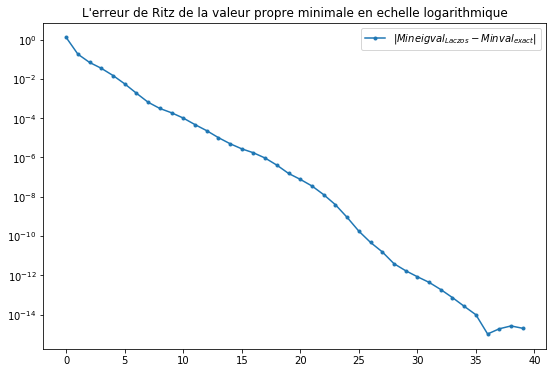

In [15]:
fig,ax = plt.subplots(1,figsize=(9,6),sharex=True)
ax.set_title(r"L'erreur de Ritz de la valeur propre minimale en echelle logarithmique")
ax.plot(erreur_ritz_min, ".-",label=r'$|Mineigval_{Laczos}-Minval_{exact}|$');
#ax.set_xscale("log")
ax.set_yscale("log")
ax.legend();

***Commentaire:***
Il y a convergence au bout de 40 itération. Alors on peut utiliser l'algo de Lanczos pour une estimation des valeurs propres sinon la methode donné par `numpy` est bien plus rapide.

### Conditionnement de A:

In [16]:
if (((A@A.T).toarray()).all() == ((A.T@A).toarray()).all()): print("A est une matrice normale car symétrique :\t A.T = A")

A est une matrice normale car symétrique :	 A.T = A


---
***Proposition:***

Si A est une matrice normale c'est à dire : $$ A^*A = AA^* $$
Alors le conditionnement $$Cond(A) = \frac {\lambda_{max}} {\lambda_{min}}$$
Donc le conditionnement de A peut être estimé à partir de $\lambda_{max}$ et $\lambda_{min}$ à l'itération `nbiter`$=40$.

---

In [17]:
print("Cond(A) ~ ",maxval[nbiter-1]/minval[nbiter-1])

Cond(A) ~  93.2303856526045


In [19]:
"""Numpy"""
print("le conditionnement de la matrice test est =\n",np.linalg.cond(A.toarray()))

le conditionnement de la matrice test est =
 93.23038565291309


***Commentaire:***
Quasiment le même!!

### Question 4: (facultative)

Il faut poser `nbiter` = taille(A) = n pour pouvoir visualiser tous les valeurs propres.

### Question 5:

In [20]:
"""definir L"""
L = np.arange(0,2.01,0.01).astype(np.float64)
L = np.concatenate((L,np.array([2.5,3.])))
#print("L=\n",L)
"""definir B"""
B = spsp.diags(L,0,dtype=np.float64)
#print("B=\n",B.toarray())

In [26]:
def Ritz_fantom(B,nbiter):
    eigval = Lanczos(B,nbiter)
    """calcul des valeurs fantomes"""
    eigval = np.sort(eigval)
    fantval = np.zeros((nbiter,2))
    fantval = eigval[:nbiter,-2:]

    return fantval

In [27]:
fantomes = Ritz_fantom(B,nbiter)
#print("valeurs fantomes d Ritz =\n",Ritz_fantom(B,nbiter))

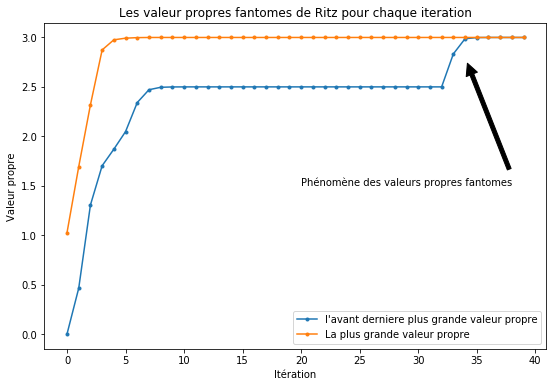

In [28]:
fig,ax = plt.subplots(1,figsize=(9,6))
ax.set_title(r"Les valeur propres fantomes de Ritz pour chaque iteration")
ax.plot(fantomes[:,0], ".-",label="l'avant derniere plus grande valeur propre");
ax.plot(fantomes[:,1], ".-",label="La plus grande valeur propre");
ax.set_ylabel('Valeur propre')
ax.set_xlabel('Itération')
ax.annotate('Phénomène des valeurs propres fantomes', xy=(34, 2.8), xytext=(20, 1.5), 
arrowprops={'facecolor':'black', 'shrink':0.05} )
ax.legend();

---
***Commentaire:***

Les valeurs propres attendus selon la matrice `B` sont `{3,2.5}` et non pas `{3,2.99}`!
    
A partir d'un certain nombre d'iterations, la la grande valeurs propre converge d'une manière stable alors que la convergence de l'avant plus grande valeur propre est suivi d'une perturbation. Cette perturbation appelé aussi phénomène des valeurs propres phantomes peut être évitée en arrétant le nombre d'itération bien avant `nbiter`$<40$. 

***Remarque:***

Je ne suis pas sur mais la question facultative 4 nous donne une bonne stratégie d'éviter ce phénomène.

---

# Partie 2: Méthode QR

Dans cette méthode, la matrice Q utilise des rotations de Givens. Chaque rotation annule un élément de la partie triangulaire inférieure stricte de la matrice, construisant la matrice R, tandis que la concaténation des rotations engendre la matrice Q.

Dans ce TP en va implémenter une version applicable seulement sur les matrices Hessenberg.

## Question 6:

***A noter:***

* Nous rappelons que la k-ième étape consiste à annuler le coefficient $A[k + 1;k]$ en multipliant (à gauche) par une matrice de Givens.

* A noter que la multiplication par la matrice $G_k$ consiste juste à faire une rotation sur les k et k+1-ième lignes.

***Remarque:***
Cette algorithme est juste seulement pour les matrices Hessenberg.

In [170]:
"""factorisation QR méthode de Givens""" 
###implémentation itérative pour une matrice type Hesenberg
 
def c(k,R): 
    """cosinus theta""" 
    return R[k,k]/np.sqrt(R[k,k]*R[k,k]+R[k+1,k]*R[k+1,k]) 

def s(k,R): 
    """sinus theta""" 
    return R[k+1,k]/np.sqrt(R[k,k]*R[k,k]+R[k+1,k]*R[k+1,k]) 

def Givens(k,A): 
    """Matrice de Givens à l'etape k""" 
    G=np.eye(len(A)) #identité 
    G[k,k]=-c(k,A) 
    G[k,k+1]=-s(k,A) 
    G[k+1,k]= s(k,A) 
    G[k+1,k+1]= -c(k,A) 
    return G 

def facto_QR_hessenberg(A):
    """calcule la transposée (donc l'inverse) du facteur Q""" 
    n=len(A)  
    Q=np.eye(n) #identité
    R = A.copy()
    for k in range(0,n-1): #n-1 élément à annuler 
        Gk = Givens(k,R) #etape k
        #print("check",R)
        Q=Gk@Q
        R = Gk@R  
    return R,Q 
    

## Question 7:

***Matrice Hessenberg exemple:***

In [171]:
n = 4
A = np.triu([ np.random.rand(n),np.random.rand(n),np.random.rand(n),np.random.rand(n)], -1)
A

array([[0.7057946218, 0.233390208 , 0.0546499671, 0.1852219688],
       [0.9323211335, 0.9936941898, 0.7686845884, 0.9004074383],
       [0.          , 0.8420226523, 0.6528529467, 0.7835346615],
       [0.          , 0.          , 0.8344637789, 0.6164958085]])

***Décomposition QR:***

In [172]:
R,Q = facto_QR_hessenberg(A)

In [173]:
"""Affichage Q R et verification Q"""
if( np.allclose(Q@Q.T,np.eye(len(A)))): print("Q est une matrice normale=\n\n",Q)
print("\nR est triangulaire superieure=\n\n",R)

Q est une matrice normale=

 [[-0.6035809447 -0.7973017265  0.            0.          ]
 [ 0.3515795002 -0.2661560609 -0.8975259363  0.          ]
 [ 0.0762533202 -0.0577260145  0.0469883166 -0.9943064098]
 [ 0.7115246512 -0.5386451664  0.4384510142  0.1065587326]]

R est triangulaire superieure=

 [[-1.1693454341 -0.9331439754 -0.6458592283 -0.8296928561]
 [ 0.           -0.938159688  -0.7713287062 -0.8777713305]
 [ 0.           -0.           -0.8392420794 -0.614021902 ]
 [ 0.           -0.            0.            0.0560244613]]


## Question 8:

In [190]:
def QR_hessenberg(A,maxiteration):
    Hj = A.copy()
    for _ in range(0,maxiteration): #convergenance vers les valeurs propre 
        Qj,Rj = facto_QR_hessenberg(Hj)
        Hj = Qj@Rj
        #print(Hj)
        valeurs = np.sort(np.abs(np.diag(Hj)))#extraire les valeurs propre en val absolue de la diagonale
    return valeurs 

In [191]:
maxiteration=2000
QR_hessenberg(A,maxiteration)

array([0.0678803506, 0.3877496024, 0.8045474737, 1.9520375089])

## Question 9:

***Matrice symétrique tridiagonale:***

In [192]:
n = 4
d = 2 
vec = np.random.rand(n-1)
B= spsp.diags([np.random.rand(n),vec,vec],[0,1,-1])
B = B.toarray() # car sp.linalg ne supporte pas diags
B

array([[0.4195893045, 0.1810150704, 0.          , 0.          ],
       [0.1810150704, 0.0714187463, 0.365551977 , 0.          ],
       [0.          , 0.365551977 , 0.4136189398, 0.5181403753],
       [0.          , 0.          , 0.5181403753, 0.3396523252]])

***Vecteurs propres selon le module "sp.linalg":***

In [193]:
valeurs,vecteurs = sp.linalg.eig(B) # cette methode donne la forme complex
valeurs

array([ 0.9854344756+0.j,  0.4863314186+0.j,  0.1141317085+0.j, -0.3416182869+0.j])

In [196]:
valeurs,vecteurs = sp.linalg.eigh(B) # cette methode donne la parie réelle
valeurs_eigh = np.sort(np.abs(valeurs))
valeurs_eigh

array([0.1141317085, 0.3416182869, 0.4863314186, 0.9854344756])

***Maintenant on compare avec l'algo QR_hessenberg:***

In [197]:
maxiteration=2000
QR_hessenberg(B,maxiteration)

array([0.1234168745, 0.239814661 , 0.4042999251, 0.9712513998])

***Pour une matrice Hessenberg quelconque:***
On doit rajouter un critere d'arret sur tous les elements en dessous de la diagonale. Donc le résultat ne sera pas bon.

***Commentair:***
    
Pour une matrice tridiagonale les valeurs propres en valeurs absolue sont identique comme montré dans l'exemple en dessus.

## Question 10:

In [209]:
maxiteration = 2000
def Lanczos_QR(A,nbiter):
    n = A.shape[0]
    assert n >= nbiter
    v = np.random.rand(n)
    v = v/ np.linalg.norm(v)
    vold = np.random.rand(n)
    vold = vold/ np.linalg.norm(vold)
    beta = 0
    Tdiag =[]
    Tdiagsup =[]
    eigval = np.zeros((n,n)) #[] #autre alternative
    for i in range(1,nbiter+1):
        alpha,beta = iter_Arnoldi_sym(A,v,vold,beta)
        Tdiag.append(alpha)
        T = np.diag(Tdiag) +np.diag(Tdiagsup,1)+np.diag(Tdiagsup,-1)
        Tdiagsup.append(beta)
        eigval[i-1,0:i] =QR_hessenberg(T,maxiteration)[0] #eigval.append(np.linalg.eig(T)[0])
        
    return eigval

In [210]:
"""test"""
Lanczos_QR(B,len(B)-1)

array([[0.5609999716, 0.          , 0.          , 0.          ],
       [0.0269309656, 0.0269309656, 0.          , 0.          ],
       [0.3317242887, 0.3317242887, 0.3317242887, 0.          ],
       [0.          , 0.          , 0.          , 0.          ]])

***Commentaire:***
je n'ai pas eu le temps pour aller au bout des verifications des calculs.